# Algorithmic recourse for Bayesian classifiers (Schut et al. 2021)

In this notebook we see how algorithmic recourse can be implemented for Bayesian classifiers. In particular, we follow the implementation in Schut et al (2021).

In [246]:
using CSV;
using DataFrames;
using LinearAlgebra;
using Distributions;
include("../src/utils.jl");

## Fitting the Bayesian classifier

In [247]:
include("../src/bayes_logreg.jl");
include("../src/optimization.jl");

In [248]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall)).

In [249]:
using RCall
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [250]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
w_0 = zeros(d); # zero-mean prior
λ = 0.005
H_0 = UniformScaling(λ);

In [251]:
model = bayes_logreg(X,y);
w = model.μ;

In [252]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];

In [253]:
y_probit = predict(model, hcat(ones(N_grid), W));
estimates = DataFrame(hcat(y_probit,W), :auto);
features = copy(df);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

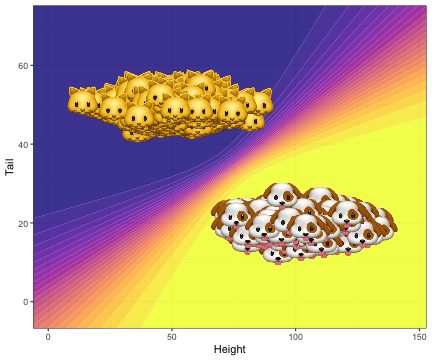

RObject{VecSxp}


In [254]:
ggplot() + 
  geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
  geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
  guides(fill="none") +
  scale_fill_viridis(option="C",discrete=true) +
  scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
  labs(x="Height", y="Tail") +
  theme_bw() # |>
  # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)

## Recourse algorithm

We have our fitted logistic regression classifier $f(\mathbf{x}^\text{CF})$. The loss for our recourse objective is $\ell(f(\mathbf{x}^\text{CF}),1))$. Using Hinge loss we have

$$\ell(f(\mathbf{x}^\text{CF}),1))=(1-z\cdot logits(f(\mathbf{x}^\text{CF}),1)))_{+}$$

where $z=1$ if $y=1$ and $z=-1$ if $y=0$. Furthermore, $logits(\cdot)$ in this particular case just refers to the linear predictions that enter the sigmoid function to produce predicted probabilities. 

This yields the following gradient for our recourse problem:

$$
\begin{aligned}
&& \nabla_{\mathbf{x}^\text{CF}} \left( \ell(f(\mathbf{x}^\text{CF}),1)) \right) &= \begin{cases} -z \cdot \hat{\mathbf{w}}  & \text{if} \ \ \ \hat{\mathbf{w}}^T\mathbf{x}^\text{CF} z \le 1\\ \mathbf{0} & \text{otherwise} \end{cases} \\
\end{aligned}
$$

## Recourse

In [255]:
include("../src/gradients.jl");
include("../src/generate_recourse.jl");

### Schut et al. 

The algorithm used to generate recourse in Schut et al. (2021) is based on the Jacobian-based Saliency Map Attack (JSMA). Let's refer to the recourse variant as Jacobian-based Saliency Map CE (JSMCE). It can be coded up as follows:

## Generating recourse

In [256]:
x_f = [50.0, 60.0]; # factual

In [257]:
recourse_wachter = generate_recourse_wachter(x_f,gradient,model,1);
recourse_schut = generate_recourse_schut(x_f,gradient,model,1;n=30);

In [258]:
path_df = DataFrame();
recourses = (wachter = recourse_wachter, schut = recourse_schut)
for i in 1:length(recourses)
    recourse_name = keys(recourses)[i]
    recourse = recourses[i]
    path = DataFrame(recourse.path, :auto)
    insertcols!(path, :type => String(recourse_name))
    insertcols!(path, :emoji=> "../www/cat.png")
    path_df = vcat(path_df, path)
end;

## Results

In [259]:
using Images, FileIO

In [260]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=1-w[1], slope=-w[2]/w[3]) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1, image_fun=R"function(img) magick::image_fx(img, expression = '0.5*a', channel = 'alpha')") +
    geom_image(data=path_df, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/path.png", plot = p, width=8, height=4);

As we can see in the figure below, the approach by Schut et al. results in a counter factual explanation with high posterior predictive likelihood. Conversely, the conventional approach (Wachter) generates recourse that lies right on the decision boundary where predictive uncertainty is very high.

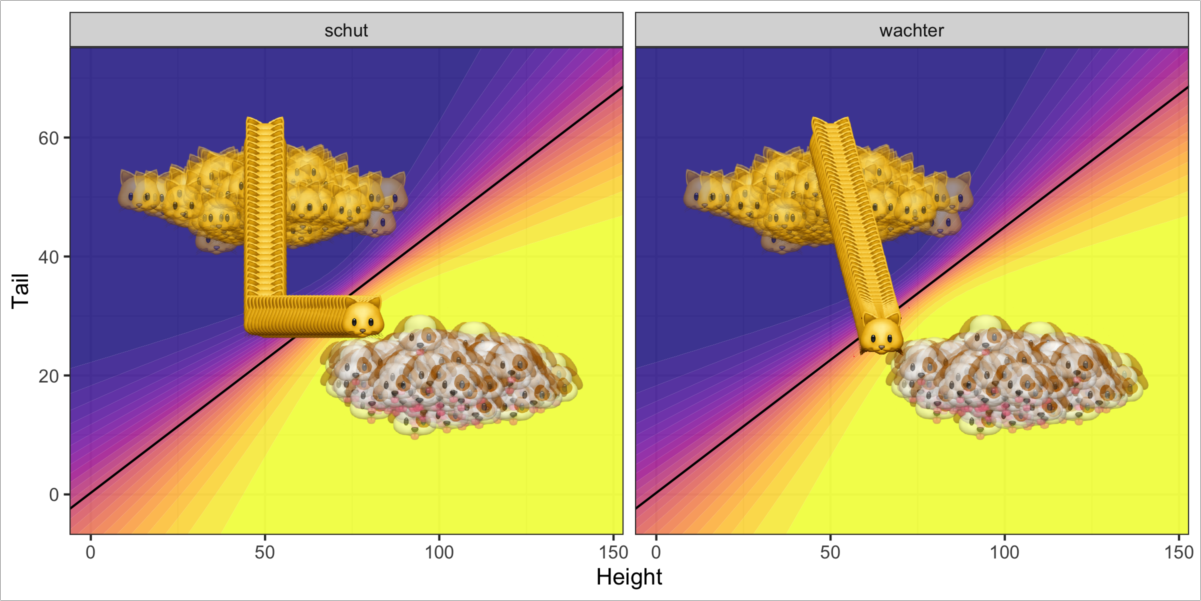

In [261]:
load("www/path.png")